## **Can <font color='darkred'>Heart Disease</font> be predicted?**

**Analysis By:**

Lisa Desjarlais, Shreyas Goyal, and Emma Szeto _(Group 155)._

**Introduction:**
    
According to medical professionals at Johns Hopkins and Mount Sinai Health, there are five classifications of heart disease: Class 0 indicates no presence of heart disease, while classes 1 to 4 describe mild, moderate, severe and very severe heart disease, in that order <a href="(https://www.hopkinsmedicine.org/news/media/releases/updated_classification_system_captures_many_more_people_at_risk_for_heart_attack">(Johns Hopkins Medicine 2017)</a>. The goal of our project is to answer the predictive question: Can we use the health attributes available to us to predict whether a future patient (with an unknown diagnosis) has heart disease? For our project we will be analyzing both the <a href="https://archive.ics.uci.edu/ml/datasets/Heart+Disease">Cleveland and Hungarian Heart Disease Data Sets.</a>  The Cleveland data set was compiled using the medical information of 303 patients, while the Hungary data set used 294 patients. Each row in the data sets represents a patient with some classification of heart disease and 13 other health attributes.

**Methods & Results**

**Preprocessing the Data**

We begin our analysis by loading in all necessary libraries and our two data sets. We are using the tidyverse library to load, wrangle and plot our data. We then proceed to wrangle, clean, add in our binary classification column, and then combine our two data sets into one heart data set, which now has the medical information of 597 patients.

In [1]:
# Loading in all necessary libraries.
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

# Setting the seed.
set.seed(14)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# Loading in Cleveland data set
URL <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

cleveland_data <- read_csv(URL, col_names=FALSE, show_col_types = FALSE)

# Since column names aren't pre-specified, we rename them using colnames, according to the UCI repository.
colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", 
                              "chol", "fbs", "restecg", "thalach", 
                              "exang", "oldpeak", "slope", "ca", "thal", "num")

cleveland_data <- cleveland_data |>
    mutate(ca = as.numeric(ca), thal = as.numeric(thal)) |>
    filter(ca != "NA", thal != "NA")

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [3]:
# Adding column indicating yes or no for presence of heart disease
cl_have_disease <- cleveland_data |>
    filter(num == 1 | num == 2 | num == 3 | num == 4) |>
    mutate(hd = "yes") |>
    mutate(hd = as_factor(hd))
cl_no_disease <- cleveland_data |>
    filter(num == 0) |>
    mutate(hd = "no") |>
    mutate(hd = as_factor(hd))
cl_data_alt <- rbind(cl_have_disease, cl_no_disease)

In [4]:
# Loading in Hungarian data set
URL2 <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data"

hungarian_data <- read_delim(URL2, col_names = FALSE, delim = " ", show_col_types = FALSE)

colnames(hungarian_data) <- c("age", "sex", "cp", "trestbps", 
                              "chol", "fbs", "restecg", "thalach", 
                              "exang", "oldpeak", "slope", "ca", "thal", "num")


# Combine levels 1,2,3,4 into hd column. Levels 1-4 as "yes", level 0 as "no."
hung_have_disease <- hungarian_data |>
    filter(num == 1 | num == 2 | num == 3 | num == 4) |>
    mutate(hd = "yes") |>
    mutate(hd = as_factor(hd))

hung_no_disease <- hungarian_data |>
    filter(num == 0) |>
    mutate(hd = "no") |>
    mutate(hd = as_factor(hd))

hung_data_alt <- rbind(hung_have_disease, hung_no_disease)

In [5]:
heart_data <- rbind(hung_data_alt, cl_data_alt) |>
    select(-num)
heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
49,0,3,160,180,0,0,156,0,1.0,2,-9,-9,yes
48,0,4,138,214,0,0,108,1,1.5,2,-9,-9,yes
37,1,4,140,207,0,0,130,1,1.5,2,-9,-9,yes
58,1,2,136,164,0,1,99,1,2.0,2,-9,-9,yes
49,1,4,140,234,0,0,140,1,1.0,2,-9,-9,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,1,2,122,192,0,0,174,0,0.0,1,0,3,no
56,1,2,130,221,0,2,163,0,0.0,1,0,7,no
56,1,2,120,240,0,0,169,0,0.0,3,0,3,no


The columns in the data represent:

1. age: age in years
2. sex: biological sex (1 = male, 0 = female)
3. cp: chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic)
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital) 
5. chol: serum cholestoral in mg/dl 
6. fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
7. restecg: resting electrocardiographic results 
   (0 = normal, 1 = having ST-T wave abnormality, 2 = probable left ventricular hypertrophy)
8. thalach: maximum heart rate achieved 
9. exang: exercise induced angina (1 = yes; 0 = no) 
10. oldpeak: ST depression induced by exercise relative to rest 
11. slope: the slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping)
12. ca: number of major vessels (0-3) colored by flourosopy 
13. thal: presence of heart defect (3 = normal, 6 = fixed defect, 7 = reversable defect)
14. num: diagnosis of heart disease (0 = none, 1 = mild, 2 = moderate, 3 = severe, 4 = very severe)

We then make note of the number of observations in our two classes. This helps us gage how well our classifier is doing, since we can compare it to the majority classifier. If our classifier can improve it's accuracy upon 59% (our majority percentage) than our method is gaining valuable information from our predictors <a href="https://datasciencebook.ca/classification2.html#critically-analyze-performance">(Timbers et al., 2022)</a>.

In [6]:
# Percentages of hd (yes, no) 
num_obs_h <- nrow(heart_data)
heart_proportions <- heart_data |>
    group_by(hd) |>
    summarize(
        count = n(),
        percentage = n() / num_obs_h * 100
        )
heart_proportions

hd,count,percentage
<fct>,<int>,<dbl>
yes,243,41.11675
no,348,58.88325


**Planned Analysis**

We now begin our K-nn classification by splitting our heart data set into a training and testing set. 75% of our data will be allocated to the training set and 25% for the testing set.

In [7]:
# Creating Training and Testing Data Sets
heart_split <- initial_split(heart_data, prop = 0.75, strata = hd)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

**Finding the Best Predictors using Forward Selection**

In order to ensure all of our group members had equal work to do, we decided to find the best predictors first before we ran our k-nn algorithm. Since we have $13$ variables to work with, we chose the method of forward selection to select the best predictors. According to the textbook, best subset selection is a method that trains all combinations of predictors and chooses the best accuracy. However, the method can become very slow once the number of predictors reaches 10 <a href="https://datasciencebook.ca/classification2.html#predictor-variable-selection">(Timbers et al., 2022)</a>. With $m = 13$ variables, we would have to train $2^m-1=8191$ models. Therefore, we chose to implement the method of forward selection, which chooses a list of candidate models and is more efficient to run (since it only trains $1/2m(m+1)=91$ models). The only tradeoff is perhaps a reduction in possible accuracy since not all possible models are trained  <a href="https://datasciencebook.ca/classification2.html#predictor-variable-selection">(Timbers et al., 2022)</a>. We felt this method fit the requirements of our project. The code for the forward selection method is from the textbook, section 6.8.3 <a href="https://datasciencebook.ca/classification2.html#predictor-variable-selection">(Timbers et al., 2022)</a>.

Warning: Code takes 8-9 min. to run

In [8]:
# Implementing Forward Selection Code to find best predictors
names <- colnames(heart_training |> select(-hd))

# Create a tibble to store accuracies
preds_accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# Create a model spec
knn_FS_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create a 5-fold cross-validation object
heart_vfold_preds <- vfold_cv(heart_training, v = 5, strata = hd)

# Stores selected predictors
selected <- c()
# For every size from 1 to 13 predictors
for (i in 1:13) {
    # Stores preds not yet added
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # For each combo of preds we are creating a model string
        # and tuning the resultant classifier while collecting the accuracy
        # of the best k
        preds_new <- c(selected, names[[j]])
        model_string <- paste("hd", "~", paste(preds_new, collapse="+"))
        heart_FS_recipe <- recipe(as.formula(model_string),
                                data = heart_training) |>
                            step_scale(all_predictors()) |>
                            step_center(all_predictors())
        acc <- workflow() |>
            add_recipe(heart_FS_recipe) |>
            add_model(knn_FS_spec) |>
            tune_grid(resamples = heart_vfold_preds, grid = 10) |>
            collect_metrics() |>
            filter(.metric == "accuracy") |>
            summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
        # Adding the result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    preds_accuracies <- preds_accuracies |>
        add_row(size = i,
                model_string = models[[jstar]],
                accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
preds_accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,hd ~ oldpeak,0.7043508
2,hd ~ oldpeak+cp,0.7813449
3,hd ~ oldpeak+cp+thal,0.8130360
4,hd ~ oldpeak+cp+thal+fbs,0.8130110
5,hd ~ oldpeak+cp+thal+fbs+slope,0.8062944
⋮,⋮,⋮
9,hd ~ oldpeak+cp+thal+fbs+slope+sex+restecg+exang+ca,0.8083895
10,hd ~ oldpeak+cp+thal+fbs+slope+sex+restecg+exang+ca+thalach,0.8039451
11,hd ~ oldpeak+cp+thal+fbs+slope+sex+restecg+exang+ca+thalach+age,0.8151061


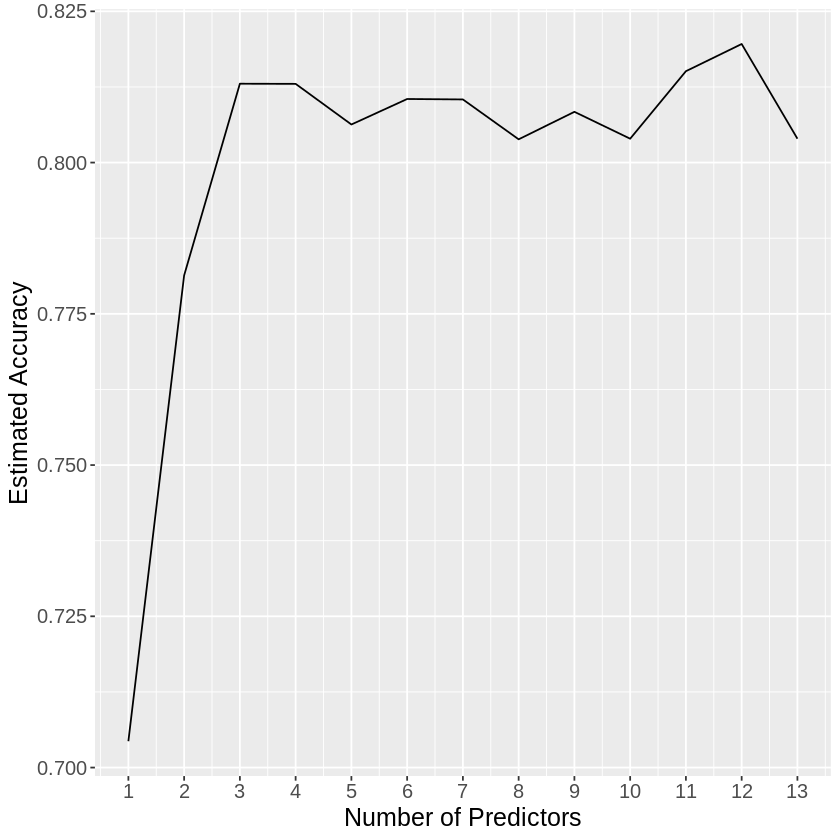

In [9]:
best_preds_plot <- ggplot(preds_accuracies, aes(x = size, y = accuracy)) +
    geom_line() +
    xlab("Number of Predictors") +
    ylab("Estimated Accuracy") +
    scale_x_continuous(breaks = 1:13) +
    theme(text = element_text(size = 15))

best_preds_plot

In [10]:
best_preds <- preds_accuracies |> slice(3,4,12)
best_preds

size,model_string,accuracy
<int>,<chr>,<dbl>
3,hd ~ oldpeak+cp+thal,0.8130360
4,hd ~ oldpeak+cp+thal+fbs,0.8130110
12,hd ~ oldpeak+cp+thal+fbs+slope+sex+restecg+exang+ca+thalach+age+chol,0.8196011


The best accuracy comes from using 12 predictors. However this may cause an overfitting of data, given that it involves a lot of predictors and it comes after some oscillation of accuracy in the data. <a href="https://pubs.acs.org/doi/10.1021/ci0342472">Hawkins (2004)</a> warns that overfitting is likely to occur when a more complex model is chosen over a simpler model with similar accuracy. According to  <a href="https://www.sciencedirect.com/science/article/pii/S0924271617303088">A.D. Rocha et al. (2017)</a>, overfitting may produce a high accuracy on the training data, but a lower accuracy on the test data. They also describe how a predictor may be irrelevant in predicting the class variable but may correlate well with another variable relevant to the class variable, resulting in a false accuracy when both variables are used. So choosing 12 predictors might not be the best option. The next best accuracy comes from using just 3 predictors, which is a lot simpler. Thus, the predictors we will choose to train our classifier are "oldpeak", "cp", and "thal". This makes sense since the ST depression induced during exercise relative to rest, chest pain and presence of heart defect are all good predictors of heart disease.

**Tuning the Classifier**

Now, we want to tune the classifier in order to identify the best value of neighbours (k), in order to get the best accuracy for our classifier. We do this by tuning our classifier, which means testing different values of k, and then comparing the results at the end in order to choose that value of k for which our classifier's accuracy is the highest.

While tuning the classifier, we can create multiple classifiers based on multiple splits of the training data itself, evaluate them and then choose a value for the neighbours we want based on all the different results. This is known as V-Fold Cross Validation. We do this in order to reduce the chances of our classifier being arbitratily good or bad, based on whether our data was lucky enough to end up in the validation set. Here, we perform a 10-fold Cross Validation, thereby using 10 different splits of our training data, in order to determine the best value of k.

Now, we first create a recipe that our classifier will follow, using the predictors that best predict heart disease, as found above. We step and scale all our predictors in order to make sure that our predictors have an equal influence on our classifier. Now, we can tune our classifier by using the nearest_neighbor() function, by setting the engine to "kknn" and mode to "classification" since we're performing a K-NN Classification. Now, we make a tibble of numbers from 1 to 50, which is a reasonable amount of neighbours to consider when we are looking at a population of 597 patients. Then, we combine everything into a workflow and produce the results of accuracies, for all the different possible values of k.

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7224967,10,0.01973460,Preprocessor1_Model01
1,roc_auc,binary,0.6842105,10,0.02162801,Preprocessor1_Model01
2,accuracy,binary,0.7270905,10,0.01656086,Preprocessor1_Model02
2,roc_auc,binary,0.7258978,10,0.02353036,Preprocessor1_Model02
3,accuracy,binary,0.7518401,10,0.01947026,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,roc_auc,binary,0.8525753,10,0.01458185,Preprocessor1_Model48
49,accuracy,binary,0.7858256,10,0.02014432,Preprocessor1_Model49
49,roc_auc,binary,0.8486580,10,0.01548871,Preprocessor1_Model49


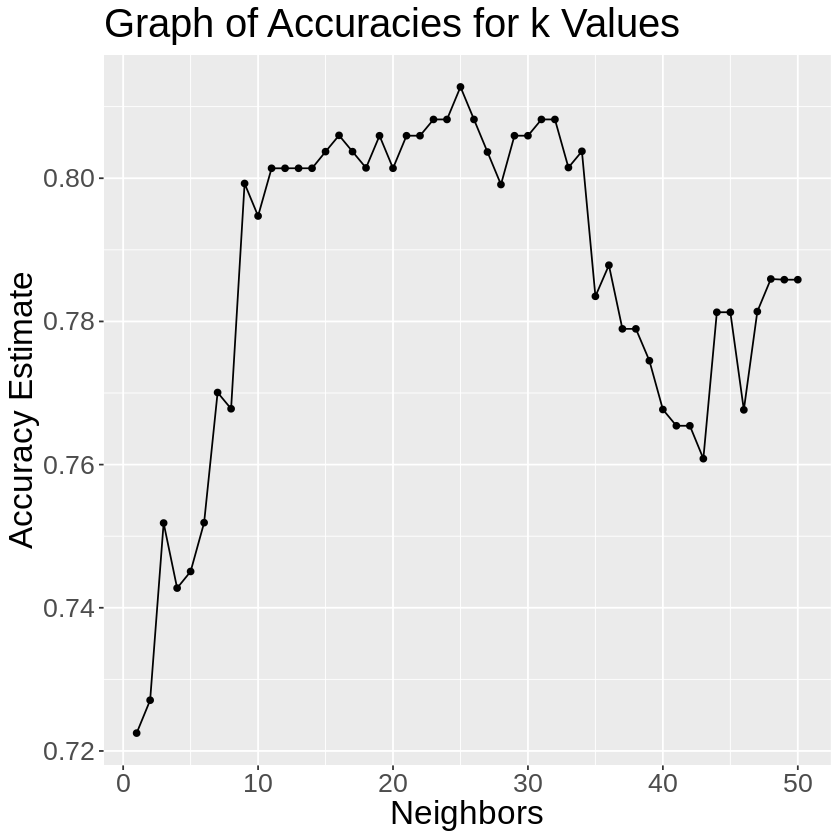

In [11]:
# Creating a 10-fold cross-validation object
set.seed(1975)
heart_vfold <- vfold_cv(heart_training, v = 10, strata = hd)

# Preparing the recipe according to the best predictors as found above
heart_recipe <- recipe(hd ~ oldpeak + cp + thal, data = heart_training) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

# K-nn Classification spec
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
              set_engine("kknn") |>
              set_mode("classification")

# Setting possible values of best K to be in between 1 and 50
gridvals <- tibble(neighbors = seq(1, 50))

# Combining everything into a workflow and collecting the metrics to identify the best value of K
knn_results <- workflow() |>
                  add_recipe(heart_recipe) |>
                  add_model(knn_spec_tune) |>
                  tune_grid(resamples = heart_vfold, grid = gridvals) |>
                  collect_metrics()

knn_results

accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Creating a cross-validation plot to visualise accuracies for the different values of K
cross_val_plot <- accuracies |> 
                    ggplot(aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate") +
                    ggtitle("Graph of Accuracies for k Values") +
                    theme(text = element_text(size = 20))

cross_val_plot

Upon graphing the accuracies of our classifier for different values of k, we can see that the best value of k is somewhere between 20 and 30. Now, we can sort the results of our accuracy results in descending order of their mean accuracy, and then pick the first entry of the tibble, which is our best k value.

In [12]:
# Choosing the best value of K
conclusions <- knn_results |>
                filter(.metric == "accuracy") |>
                select(neighbors, mean, std_err) |>
                arrange(mean) |>
                tail(1)

conclusions

neighbors,mean,std_err
<int>,<dbl>,<dbl>
25,0.8127536,0.0166563


**From the above conclusions, we can see that the best value for K to be used is 25.**

Now that we have identified the best value for K, we can make a new model specification for the best value of K and retrain the classifier. We will use the k-nearest neighbors to create a model specification with K = 25 and combine the model specification into a workflow that inlcudes the recipe we previously made. Following, we will use the fit function to build the classifier. We will do so using the training data as we want to keep the testing data for the following steps. 

In [13]:
#Retraining the classifer 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    fit(data = heart_training)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(25,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1873589
Best kernel: rectangular
Best k: 25

After retraining the classifier, we can now test our classifer by using it to predict labels on our test set. We will use the predict function on our testing set and the bind_cols functuon to merge the column of our predictions to the original data set. Therefore, we will be able to make a direct comparison of the predicted labels to the actual labels, with ".pred_class" representing our predictions and "hd" representing the true diagnosis. 

In [14]:
#Predicting the labels in the test set
heart_test_predictions <- predict(knn_fit, heart_testing) |>
    bind_cols(heart_testing)
heart_test_predictions 

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
yes,37,1,4,140,207,0,0,130,1,1.5,2,-9,-9,yes
yes,65,1,4,140,306,1,0,87,1,1.5,2,-9,-9,yes
no,54,0,3,130,294,0,1,100,1,0.0,2,-9,-9,yes
yes,41,1,4,110,289,0,0,170,0,0.0,-9,-9,6,yes
yes,47,0,4,120,205,0,0,98,1,2.0,2,-9,6,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
no,51,0,3,120,295,0,2,157,0,0.6,1,0,3,no
no,76,0,3,140,197,0,1,116,0,1.1,2,0,3,no
no,44,0,3,118,242,0,0,149,0,0.3,2,1,3,no


After predicting the labels on the testing set, we can follow our analysis by assessing our classifier's accuracy. In prder to determine the quality of our model that we trained, we can use the metrics functions from tidymodels. We specify the column containing the true results in the truth argument and we use the estimate argument to denote which column contains our predictions. Further, we use the filter function to view the accuracies row contained in the .metric column. This step will help us analyze the performance of our classifer and it will give us an estimated accuracy. 

In [15]:
#Computing the accuracy
heart_accuracies <- heart_test_predictions |>
    metrics(truth = hd, estimate = .pred_class) |>
    filter(.metric =="accuracy")
heart_accuracies

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8243243


The final step in our classification is to look at the confusion matrix for the classfier. This is a table that will compare the predicted labels against the correct labels. We can do so by using the conf_mat function and again, specifying which columns contains our predictions and also which column contains the true values. By conducting this final step, we can get a numerical representation of how many labels our classifer was able to successfully predict. 

In [16]:
#Looking at the confusion matrix
confusion <- heart_test_predictions |>
             conf_mat(truth = hd, estimate = .pred_class)
confusion 

          Truth
Prediction yes no
       yes  44  9
       no   17 78

After looking at the confusion matrix for the classifier, we can see that 44 observations were correcty predicted as "yes" and 78 observations were correctly predicted as "no". However, our classifer did make some mistakes as it misclassified 9 observations as "yes" and 17 observations as "no".

**Discussion**

1. summarize what you found
2. discuss whether this is what you expected to find?
3. discuss what impact could such findings have?
4. discuss what future questions could this lead to?

**References (APA)**

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Johns Hopkins Medicine (2017, January 11). _Updated Classification System Captures Many More People at Risk for Heart Attack_. https://www.hopkinsmedicine.org/news/media/releases/updated_classification_system_captures_many_more_people_at_risk_for_heart_attack

Hawkins, D. M. (2004). The problem of overfitting. Journal of Chemical Information and Computer Sciences, 44(1), 1-12. https://doi.org/10.1021/ci0342472

Rocha, A. D., Groen, T. A., Skidmore, A. K., Darvishzadeh, R., & Willemen, L. (2017). The naïve overfitting index selection (NOIS): A new method to optimize model complexity for hyperspectral data. ISPRS Journal of Photogrammetry and Remote Sensing, 133, 61-74. https://doi.org/10.1016/j.isprsjprs.2017.09.012

Timbers, T., Campbell, T., & Lee, M. (2022). Data science: A first introduction. CRC Press LLC.

**Notes for teammates**

The tuning of the classifier neighbours change slightly to k = 24 -> k = 26 when run out of order, for some reason. Just make sure everything is run in order. - Sorted.